# Differentiable TT Cross-approximation: Example

In [1]:
import tntorch as tn
import torch
torch.set_default_dtype(torch.float64)  # Note: float32 is sometimes unstable
torch.manual_seed(0)

### Example 1: Single Optimization

We will optimize the problem $\arg \min_{\mathcal{T}} \|\cos \mathcal{T}\|$ (element-wise cosine) using Adam on the adaptive TT-cross interpolation formula.

In [2]:
# Initial solution; we constrain our search to rank-5 tensors
t = tn.rand(32, 32, 32, ranks_tt=5, requires_grad=True)

function = lambda x: torch.cos(x)

# Optimization
optimizer = torch.optim.Adam(t.cores)
for it in range(2000):
    optimizer.zero_grad()
    
    if it % 400 == 0:  # Update cross indices
        _, info = tn.cross(tensors=[t], function=function, verbose=False, return_info=True)

    # Forward pass
    t2 = tn.cross_forward(tensors=[t], function=function, info=info)
    loss = tn.norm(t2)

    if it % 200 == 0:
        print('{:04}: loss={:g}'.format(it, loss))
    loss.backward()
    optimizer.step()

0000: loss=133.653
0200: loss=41.3387
0400: loss=4.57952
0600: loss=1.38465
0800: loss=0.503446
1000: loss=0.270926
1200: loss=0.19317
1400: loss=0.153916
1600: loss=0.130659
1800: loss=0.115443


In [3]:
print(t)

3D TT tensor:

 32  32  32
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   5   5   1



In [4]:
print(t.torch())

tensor([[[1.5708, 1.5707, 1.5707,  ..., 1.5705, 4.7115, 1.5705],
         [1.5707, 1.5706, 1.5706,  ..., 1.5702, 4.7118, 1.5707],
         [1.5704, 1.5704, 1.5704,  ..., 1.5705, 4.7118, 1.5704],
         ...,
         [1.5710, 1.5709, 1.5707,  ..., 1.5700, 4.7114, 1.5707],
         [1.5707, 1.5706, 1.5707,  ..., 1.5707, 4.7118, 1.5705],
         [1.5702, 1.5702, 1.5702,  ..., 1.5706, 4.7118, 1.5703]],

        [[1.5703, 1.5703, 1.5704,  ..., 1.5704, 4.7117, 1.5704],
         [1.5703, 1.5703, 1.5703,  ..., 1.5704, 4.7116, 1.5704],
         [1.5704, 1.5703, 1.5704,  ..., 1.5704, 4.7117, 1.5704],
         ...,
         [1.5703, 1.5703, 1.5703,  ..., 1.5704, 4.7116, 1.5704],
         [1.5703, 1.5703, 1.5704,  ..., 1.5704, 4.7119, 1.5704],
         [1.5704, 1.5704, 1.5704,  ..., 1.5704, 4.7115, 1.5704]],

        [[1.5702, 1.5703, 1.5703,  ..., 1.5704, 4.7114, 1.5703],
         [1.5705, 1.5704, 1.5704,  ..., 1.5704, 4.7116, 1.5705],
         [1.5707, 1.5705, 1.5706,  ..., 1.5702, 4.7117, 1.

### Example 2: Joint Optimization

We will now find $\mathcal{T}_1, \mathcal{T}_2$ such that $\|\mathcal{T}_1^2 + \mathcal{T}_2^2 - 1\|$ is minimal.

In [5]:
t1 = tn.rand(16, 16, 16, 16, ranks_tt=3, requires_grad=True)
t2 = tn.rand(16, 16, 16, 16, ranks_tt=3, requires_grad=True)

function = lambda x, y: x**2 + y**2

# Optimization
optimizer = torch.optim.Adam(t1.cores + t2.cores)
for it in range(2000):
    optimizer.zero_grad()
    
    if it % 400 == 0:  # Update cross indices
        _, info = tn.cross(tensors=[t1, t2], function=function, verbose=False, return_info=True)

    # Forward pass
    t3 = tn.cross_forward(tensors=[t1, t2], function=function, info=info)
    loss = tn.norm(t3-1)

    if it % 200 == 0:
        print('{:04}: loss={:g}'.format(it, loss))
    loss.backward()
    optimizer.step()

0000: loss=2407.16
0200: loss=275.716
0400: loss=125.413
0600: loss=71.8586
0800: loss=46.5382
1000: loss=30.6674
1200: loss=19.8756
1400: loss=13.2586
1600: loss=9.2578
1800: loss=6.68817


### Example 3: Fixed Grid

Differentiable cross-approximation can be also used to find parameters $\pmb{\theta}$ such that $f(\pmb{x}, \pmb{\theta})$ satisfies some property for all $\pmb{x} \in \Omega$, where $\Omega$ is a fixed (no to be optimized) grid of points.

In this toy example, we will find $w_1, w_2, b$ such that the simple neural network $\tanh(w_1 x_1 + w_2 x_2 + b)$ is as close to $0.5$ as possible for all $(x_1, x_2) \in [-1, 1]^2$.

In [6]:
N = 2
I = 64
domain = [torch.linspace(-1, 1, I) for n in range(N)]


# Super-simple 1-layer MLP
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.linear = torch.nn.Linear(N, 1, bias=True)
        
    def forward(self, Xs):
        Xs = self.linear(Xs)
        return torch.tanh(Xs)

    
net = Net()
function = net.forward

Let us visualize the network's response over the domain $\Omega = [-1, 1]^2$:

Cross-approximation over a 2D domain containing 4096 grid points:
iter: 0  | eps: 5.079e-01 | total time:   0.0063 | largest rank:   1
iter: 1  | eps: 1.222e-05 | total time:   0.0261 | largest rank:   4
iter: 2  | eps: 1.377e-09 | total time:   0.0378 | largest rank:   7 <- converged: eps < 1e-06
Did 2304 function evaluations, which took 0.001031s (2.235e+06 evals/s)



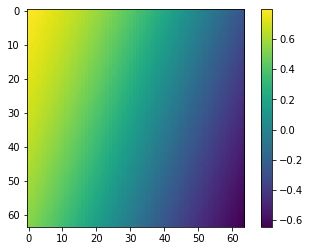

In [8]:
import matplotlib.pyplot as plt

def visualize_net():
    t = tn.cross(domain=domain, function=function, function_arg='matrix')
    plt.figure()
    plt.imshow(t.numpy())
    plt.colorbar()
    plt.show()
    
visualize_net()

We now optimize the network:

In [9]:
# Optimization
optimizer = torch.optim.Adam(net.parameters())
for it in range(2000):
    optimizer.zero_grad()
    
    if it % 400 == 0:  # Update cross indices
        _, info = tn.cross(domain=domain, function=function, function_arg='matrix', verbose=False, return_info=True)

    # Forward pass
    t2 = tn.cross_forward(domain=domain, function=function, info=info, function_arg='matrix')
    loss = tn.norm(t2-0.5)

    if it % 200 == 0:
        print('{:04}: loss={:g}'.format(it, loss))
    loss.backward()
    optimizer.step()

0000: loss=33.3485
0200: loss=18.9223
0400: loss=7.43317
0600: loss=1.24353
0800: loss=0.0103478
1000: loss=0.00480166
1200: loss=0.00513987
1400: loss=0.00359209
1600: loss=0.00339219
1800: loss=0.00377836


Finally, let's check that the resulting network satisfies the property we wanted:

Cross-approximation over a 2D domain containing 4096 grid points:
iter: 0  | eps: 1.167e-11 | total time:   0.0100 | largest rank:   1 <- converged: eps < 1e-06
Did 192 function evaluations, which took 0.0003726s (5.152e+05 evals/s)



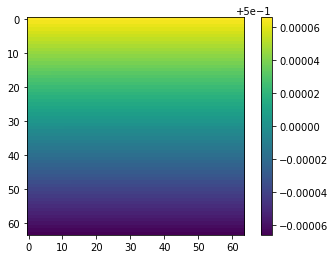

In [10]:
visualize_net()